In [1]:
import sys
import torch
import global_variables as gv
import sys
import numpy as np
import matplotlib.pyplot as plt
import configparser
from FACTS_Modules.Model import model_factory
from FACTS_Modules.util import string2dtype_array
from FACTS_Modules.TADA import MakeGestScore
from facts_visualizations import single_trial_plots, multi_trial_plots
import os 
import pdb
import seaborn as sns

In [24]:
def simulator(theta):
    ini='DesignC_AUKF_onlinepertdelay.ini'
    gFile='GesturalScores/KimetalOnlinepert2.G'
    config = configparser.ConfigParser()
    config.read(ini)

    # Replace the parameter value from ini file
    #pdb.set_trace()
    try:
        if theta.dim() > 1:
#             pdb.set_trace()
            print(theta.numel())
            config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0][0].item())
            config['SensoryNoise']['Somato_sensor_scale'] = str(theta[0][1].item())
        else:
            #pdb.set_trace()
            config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0].item())
            config['SensoryNoise']['Somato_sensor_scale'] = str(theta[1].item())
    except:
        pdb.set_trace()

    model = model_factory(config)
    #pdb.set_trace()
    if 'MultTrials' in config.sections(): 
        ntrials = int(config['MultTrials']['ntrials'])
        target_noise= float(config['MultTrials']['Target_noise'])
    else: 
        ntrials = 1
        target_noise = 0

    #pdb.set_trace()
    gest_name = gFile.split('/')[-1].split('/')[-1]
    np.random.seed(100)
    GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)
    
    # initialize vectors to monitor position at each timestep
    x_tilde_delaywindow = np.full([20,gv.x_dim*2], np.nan) #a new variable that state estimators will have a partial access to
    a_tilde_delaywindow = np.full([20,gv.a_dim*2], np.nan) #a new variable that state estimators will have a partial access to


    x_tilde_record = np.full([last_frm+20,gv.x_dim*2], np.nan) #changed
    somato_record = np.full([last_frm+20,gv.a_dim*2], np.nan) #changed
    formant_record = np.full([last_frm+20,3], np.nan) #changed
    a_tilde_record = np.full([last_frm+20,gv.a_dim*2], np.nan) #changed
    formants_produced_record = np.full([last_frm,3], np.nan)

    x_tilde_record_alltrials = np.empty([ntrials,last_frm+20,gv.x_dim]) #changed
    somato_record_alltrials = np.full([ntrials,last_frm+20,gv.a_dim*2], np.nan) #changed
    formant_record_alltrials = np.full([ntrials,last_frm+20,3], np.nan) #changed
    shift_record_alltrials = np.full([ntrials,last_frm+20,3], np.nan) #changed
    formants_produced_record_alltrials = np.full([ntrials,last_frm,3], np.nan)

    
    a_tilde_record_alltrials = np.empty([ntrials,last_frm+20,gv.a_dim])
    a_dot_record_alltrials = np.empty([ntrials,last_frm+20,gv.a_dim])
    a_dotdot_record_alltrials = np.empty([ntrials,last_frm+20,gv.a_dim])
    predict_formant_record_alltrials = np.empty([ntrials,last_frm+20,3])

    #Check if catch trials (no perturbation) are specified in the config file
    if 'CatchTrials' in config.keys():
        catch_trials = string2dtype_array(config['CatchTrials']['catch_trials'], dtype='int')
        catch_types = string2dtype_array(config['CatchTrials']['catch_types'], dtype='int')
        if len(catch_trials) != len(catch_types):
            raise Exception("Catch trial and catch type lengths not matching, please check the config file.")
    else: catch_trials = np.array([])

    #Run FACTS for each trial
    for trial in range(ntrials):
        print("trial:", trial)
        #Gestural score (task)
        GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)         #this is similar with MakeGest in the matlab version

        # initial condition
        x_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        x_tilde_record[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_record[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        a_actual = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        model.artic_sfc_law.reset_prejb() #save the initial artic-to-task model.

        if trial in catch_trials: catch = catch_types[np.where(catch_trials==trial)[0][0]]
        else: catch = False
        print("catch:", catch)
        
        for i_frm in range(last_frm): #gotta change this hardcoded number to aud delay later
            #model function runs FACTS by each frame
            x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced = model.run_one_timestep(x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, GestScore, ART, ms_frm, i_frm, trial, catch)
            a_tilde_record[i_frm+1] = a_tilde_delaywindow[0,:] #0 is always the most recnet current frame
            x_tilde_record[i_frm+1] = x_tilde_delaywindow[0,:] #0 is always the most recnet current frame
            formants_produced_record[i_frm] = formants_produced
            #pdb.set_trace()
           #save the FACTS results
            
        
        predict_formant_record_alltrials[trial,] = y_hat
        formants_produced_record_alltrials[trial,] = formants_produced_record
        
        a_tilde_record_alltrials[trial,] = a_tilde_record[:,0:gv.a_dim]
        #a_dot_record[trial, ] = a_tilde[gv.a_dim:]
        x_tilde_record_alltrials[trial,] = x_tilde_record[:,0:gv.x_dim]
        formant_record_alltrials[trial,] = formant_record
        somato_record_alltrials[trial,] = somato_record
        
        model.task_state_estimator.update(catch)
        
        del x_tilde_record
        del a_tilde_record
        del formant_record
        del somato_record
    #pdb.set_trace()
    return formants_produced_record_alltrials[:,:,0].squeeze() 


### Run an example trial, or do a parameter sweep

Auditory:
High - 0.04
Low - 0.0001

Somatosensory:
High - 10
Low - .002


param_value [0.0018, -0.1]
2
Artic SFC Law Model Type:  lwpr
[0.95759998 3.16619995 4.66019992]
[-3999999.00062613   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271]
Task State Estimator Model Type:  lwpr
trial: 0
catch: False


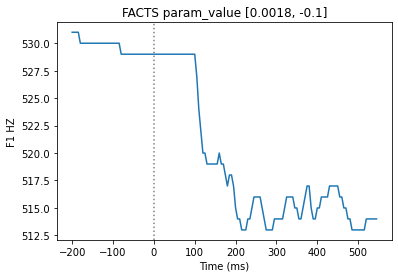

(150,)


In [73]:
# Print an example trial 
examples = []
# mu1 = 0.005
param_values = [ [0.0018, -0.1] ] #np.linspace(4, 10, num=10)
plot = True

for ii in param_values:
    print(f"param_value {ii}")
    example = simulator(torch.tensor([ii]))
    examples.append(example)
    
    if plot == True:
        plt.figure()
        plt.title(f'FACTS param_value {ii}')
        example_x = (np.arange(len(example))*5)-200
        plt.plot(example_x,example)
        plt.axvline(x = 0, color = 'grey', ls=':')
        plt.xlabel('Time (ms)')
        plt.ylabel('F1 HZ')
        plt.show()
        


### Load Kyunghee's data and compare to FACTS

(1, 194)
(1797, 194)
(1, 150)
(1797, 150)


Text(0, 0.5, 'F1 HZ')

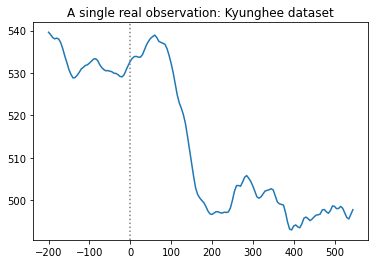

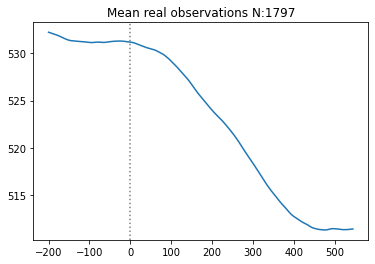

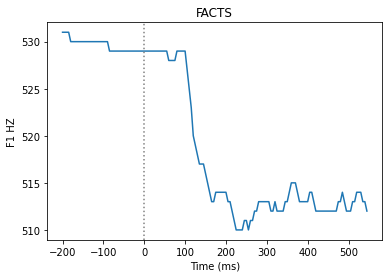

In [51]:
# Import real observed data
import scipy.io
example = examples[0]

trial_cells_times = scipy.io.loadmat('sbi_resources/formant_pert_time_cleaned.mat')['time_matrix'].T
trial_cells_mat = scipy.io.loadmat('sbi_resources/formant_pert_data_cleaned.mat')['cleaned_matrix'].T # 1797 x 194 == trials by time

print(trial_cells_times.shape)
print(trial_cells_mat.shape)
trial_cells_times = trial_cells_times[:,0:150]
trial_cells_mat = trial_cells_mat[:,0:150]
print(trial_cells_times.shape)
print(trial_cells_mat.shape)

# # Alter the trial_cells so that they center to where FACTS centers
trial_cells_mat = trial_cells_mat + 531

# Plot and compare observed data to FACTS data
plt.plot(trial_cells_times[0,:]*1000, trial_cells_mat[729,:])
plt.axvline(x = 0, color = 'grey', ls=':')
plt.title('A single real observation: Kyunghee dataset')
# plt.ylim([510,535])

plt.figure()
plt.plot(trial_cells_times[0,:]*1000, np.mean(trial_cells_mat, 0))
plt.axvline(x = 0, color = 'grey', ls=':')
plt.title(f'Mean real observations N:{(trial_cells_mat.shape[0])}')
# plt.ylim([510,535])

# # Now realign so that 
plt.figure()
plt.title('FACTS')
example_x = (np.arange(len(example))*5)-200
plt.plot(example_x,example)
plt.axvline(x = 0, color = 'grey', ls=':')
plt.xlabel('Time (ms)')
plt.ylabel('F1 HZ')
# plt.ylim([510,535])

In [ ]:
print(np.min(trial_cells_mat[729,:]))
print(np.min(np.mean(trial_cells_mat, 0)))
# print(np.min(example))

In [75]:
from sbi.inference import infer
from sbi import utils as utils
import pickle
# import facts_for_SBI

load_instead = False

#Auditory
# High - 0.04
# Low - 0.0001
#Somatosensory
# High - 10
# Low - .002
# import your simulator, define your prior over the parameters
#prior_mean = 0.002
prior_min= [0.0001, 0.002]
prior_mmax = [0.04, 1.0] 
num_sim = 100000

# prior = torch.distributions.Uniform(torch.as_tensor(mmin), torch.as_tensor(mmax) )
if load_instead == False:
    prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )
    parameter_posterior = infer(simulator, prior, method='SNPE', num_simulations=num_sim, num_workers=8)
    with open(f'./sbi_resources/ModelC_auditory_soma_noise_posterior_{num_sim}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([parameter_posterior], f)
    
else:
    file = open(f'./sbi_resources/ModelC_auditory_soma_noise_posterior_{num_sim}.pkl', 'rb')
    object_file = pickle.load(file)
    pdb.set_trace()
    file.close()

4
Artic SFC Law Model Type:  lwpr
[ 7.23054918 23.90702257 35.18776659]
[-3999999.00062613   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271]
Task State Estimator Model Type:  lwpr
trial: 0
catch: False
Artic SFC Law Model Type:  lwpr
[ 8.42419533 27.85368345 40.99669496]
[-3999999.00062613   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.66669271   166666.66669271
   166666.66669271   166666.66669271   166666.6

Running 100000 simulations in 100000 batches.:   0%|          | 0/100000 [00:00<?, ?it/s]

Neural network successfully converged after 27 epochs.


## Sample the posterior for a single point from Kyunghee's observations

In [72]:
print(single_trial.shape)
print()

(150,)


In [81]:
import pandas as pd
pd.options.display.max_rows = 4000

mean_trials = np.mean(trial_cells_mat, 0)
single_trial = trial_cells_mat[729]

samples = parameter_posterior.sample((10,), x=single_trial)
log_probability = parameter_posterior.log_prob(samples, x=single_trial)
# out = utils.pairplot(samples, fig_size=(10,6), upper='kde', diag='kde')
test = samples.numpy()
# print(test[0])
n, bins, patches = plt.hist(test, density=True, bins=30)
plt.ylabel('Density')
plt.xlabel('Auditory noise scale')

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

ValueError: Expected value argument (Tensor of shape (10000, 2)) to be within the support (Interval(lower_bound=tensor([1.0000e-04, 2.0000e-03]), upper_bound=tensor([0.0400, 1.0000]))) of the distribution Uniform(low: torch.Size([2]), high: torch.Size([2])), but found invalid values:
tensor([[ 7.4564e-03,  9.2063e-01],
        [-2.0533e-04,  4.5032e-01],
        [ 2.9625e-03,  4.6976e-01],
        ...,
        [ 3.2537e-02,  3.1802e-01],
        [-1.5892e-03,  3.7806e-01],
        [ 2.8459e-02,  5.6290e-01]])

## Sample the posterior for a single data point from the FACTS model itself

In [80]:
samples = parameter_posterior.sample((100,), x=example)
log_probability = parameter_posterior.log_prob(samples, x=example)
out = utils.pairplot(samples, fig_size=(10,6), upper='kde', diag='kde')

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Expected value argument (Tensor of shape (100, 2)) to be within the support (Interval(lower_bound=tensor([1.0000e-04, 2.0000e-03]), upper_bound=tensor([0.0400, 1.0000]))) of the distribution Uniform(low: torch.Size([2]), high: torch.Size([2])), but found invalid values:
tensor([[ 2.6276e-02,  8.0846e-02],
        [ 1.9087e-02,  5.0654e-01],
        [ 2.9535e-02,  4.0351e-01],
        [ 4.1404e-02,  5.0945e-01],
        [ 1.9808e-02,  5.3714e-01],
        [ 4.4230e-02,  1.1902e+00],
        [ 1.4088e-02,  5.7769e-01],
        [ 4.0415e-02,  1.2205e+00],
        [ 2.6754e-02,  7.5186e-01],
        [ 2.6045e-02,  1.0825e+00],
        [ 1.6262e-02,  9.3974e-01],
        [ 2.7371e-02,  7.3977e-01],
        [ 4.5153e-02,  6.7380e-01],
        [ 4.2566e-02,  4.0280e-01],
        [ 3.7253e-02,  6.1470e-01],
        [ 1.4433e-02,  9.5755e-02],
        [ 1.8174e-02, -2.9536e-01],
        [ 1.4305e-02,  3.1004e-01],
        [ 6.4073e-05,  4.7999e-01],
        [ 2.1624e-02,  1.5938e-01],
        [ 1.4726e-02,  6.3611e-01],
        [-2.6328e-03, -1.9761e-01],
        [ 3.3839e-02,  5.2489e-01],
        [ 1.8676e-02,  5.3403e-01],
        [ 3.1101e-02,  8.4899e-01],
        [ 8.1276e-03,  4.9813e-02],
        [ 2.9509e-02,  6.6192e-01],
        [ 1.8825e-02,  9.7547e-01],
        [ 3.2561e-02,  2.6089e-01],
        [ 1.5270e-02,  7.7918e-01],
        [ 6.2990e-03,  8.0785e-01],
        [ 3.3169e-02,  3.5042e-01],
        [ 6.5583e-03,  1.3136e+00],
        [ 7.1743e-03,  2.3728e-01],
        [ 1.6855e-02,  5.3549e-01],
        [ 3.0931e-02, -4.5837e-01],
        [ 2.7755e-02,  4.8433e-01],
        [ 2.7131e-02,  2.5805e-01],
        [ 1.9613e-02,  4.9691e-01],
        [ 3.0484e-02,  3.2899e-01],
        [ 2.1578e-02,  3.3277e-01],
        [ 1.4393e-02,  6.0915e-01],
        [ 4.8412e-03,  1.7077e-01],
        [ 3.1630e-02, -3.7773e-02],
        [ 4.8508e-02,  2.3945e-01],
        [ 2.6250e-02,  1.0421e+00],
        [ 1.5100e-02,  1.5812e+00],
        [ 1.3845e-02,  2.5179e-01],
        [ 1.5520e-02,  3.2812e-01],
        [ 3.0859e-02, -4.2736e-01],
        [ 3.2931e-02,  1.1338e+00],
        [ 2.0473e-02,  6.5203e-01],
        [ 1.3923e-02, -7.2365e-02],
        [ 3.8682e-02,  8.7398e-01],
        [ 1.6719e-02,  5.8904e-01],
        [ 2.3075e-02,  2.4141e-01],
        [ 3.7920e-02,  6.3751e-01],
        [ 1.5566e-02,  1.9559e-01],
        [ 2.8099e-02,  1.7142e-02],
        [ 1.6691e-02, -3.5165e-02],
        [ 3.0054e-02,  2.5242e-01],
        [ 1.7728e-02,  4.0617e-01],
        [ 1.6261e-02,  1.1326e+00],
        [ 2.1651e-02,  1.0456e+00],
        [ 1.7541e-02,  9.2774e-01],
        [ 3.9761e-04,  4.7138e-01],
        [ 2.4434e-02,  1.6671e-01],
        [ 1.7671e-02,  6.6394e-01],
        [ 2.3518e-02,  6.1682e-01],
        [ 1.1305e-02,  3.4394e-01],
        [ 4.2549e-02,  6.2117e-01],
        [ 1.8172e-02,  1.1429e+00],
        [ 6.4632e-03,  6.1432e-01],
        [ 1.4502e-02,  5.1885e-01],
        [ 2.0029e-02,  1.1659e+00],
        [ 4.1194e-04,  7.1472e-01],
        [ 3.7048e-02,  5.2727e-02],
        [ 3.9314e-02,  4.8229e-01],
        [ 3.1411e-02,  3.2227e-01],
        [ 1.2002e-02,  4.2760e-01],
        [ 4.7533e-03,  4.1339e-01],
        [ 2.2081e-02,  9.7139e-02],
        [ 8.0410e-03,  7.1700e-01],
        [ 2.4445e-02,  5.1734e-02],
        [ 2.0958e-02,  1.1179e-01],
        [-4.7379e-03,  1.1740e+00],
        [ 4.5736e-02,  1.2159e-01],
        [ 1.7450e-02,  2.9351e-01],
        [ 2.5785e-02, -8.2981e-02],
        [ 1.3693e-02,  8.3516e-01],
        [ 2.2083e-02,  2.2210e-01],
        [ 3.3295e-02,  1.9718e-01],
        [ 3.7900e-02,  8.1459e-01],
        [ 2.2036e-02,  3.0398e-01],
        [ 3.9431e-02,  1.4521e-01],
        [ 4.1099e-02,  5.5756e-02],
        [ 1.8502e-02,  1.5294e-01],
        [ 2.5664e-02, -2.7762e-01],
        [ 3.8192e-02,  1.8666e-01],
        [ 1.4550e-02,  6.3751e-01]])

## Now plot for the mean of all trials

In [78]:
samples = parameter_posterior.sample((100,), x=mean_trials)
log_probability = parameter_posterior.log_prob(samples, x=mean_trials)
out = utils.pairplot(samples, fig_size=(10,6), upper='kde', diag='kde')

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Expected value argument (Tensor of shape (100, 2)) to be within the support (Interval(lower_bound=tensor([1.0000e-04, 2.0000e-03]), upper_bound=tensor([0.0400, 1.0000]))) of the distribution Uniform(low: torch.Size([2]), high: torch.Size([2])), but found invalid values:
tensor([[ 1.8977e-02,  1.0121e+00],
        [ 1.8689e-02,  4.4121e-01],
        [ 6.2005e-03,  5.6138e-01],
        [ 2.1611e-02,  2.2551e-01],
        [ 3.7783e-03,  8.9301e-01],
        [ 1.5088e-02,  9.0167e-01],
        [ 2.7212e-02,  8.1067e-01],
        [ 2.3330e-02,  6.9646e-01],
        [ 2.7859e-02,  5.7665e-01],
        [ 3.0679e-02,  8.3717e-01],
        [ 2.1418e-02,  5.3931e-01],
        [ 2.5459e-02,  5.9246e-01],
        [ 2.0577e-02,  9.5661e-01],
        [ 1.8234e-02,  3.5775e-01],
        [ 2.1447e-02,  5.8665e-01],
        [ 8.9060e-03,  4.3716e-01],
        [ 3.0914e-03,  4.2606e-01],
        [ 1.3988e-02,  7.6664e-01],
        [ 2.5606e-02,  8.5416e-01],
        [ 8.9231e-03,  1.6561e-01],
        [ 2.0885e-02,  9.1874e-02],
        [ 1.5657e-02,  3.2012e-01],
        [ 9.0631e-03,  6.4047e-01],
        [ 2.1889e-02,  1.4412e-01],
        [ 2.4320e-02,  6.4227e-01],
        [ 2.4314e-02, -4.5767e-02],
        [ 1.9815e-02,  5.3298e-02],
        [ 4.0361e-02,  4.0118e-01],
        [ 2.2506e-02,  9.7342e-01],
        [ 1.1579e-02,  3.4111e-01],
        [ 2.4759e-02,  1.2812e+00],
        [ 1.0675e-02,  1.5761e-02],
        [ 3.5214e-02,  5.7370e-01],
        [-8.5248e-03,  3.2333e-01],
        [ 8.7970e-03,  6.2707e-01],
        [ 3.4038e-02, -2.5501e-01],
        [ 1.6796e-02,  3.3120e-01],
        [ 1.8678e-02,  8.0110e-01],
        [ 3.7420e-03,  1.1441e+00],
        [ 3.5831e-02,  4.4251e-01],
        [-5.2762e-03,  4.4951e-01],
        [ 2.3555e-02,  4.8701e-01],
        [ 2.8432e-02,  2.1321e-01],
        [ 1.1842e-02,  9.3072e-01],
        [ 1.8864e-02,  4.9054e-01],
        [ 3.3889e-02,  7.1009e-01],
        [ 3.3445e-02, -2.2470e-02],
        [ 2.8147e-02,  5.7993e-01],
        [ 1.6776e-02,  9.0683e-01],
        [ 3.5852e-02,  3.7579e-01],
        [ 3.3017e-02,  4.5872e-01],
        [ 8.9785e-03,  2.3751e-03],
        [ 3.0787e-02, -1.0092e-01],
        [ 3.4985e-02,  6.4700e-01],
        [ 3.9340e-02, -2.2172e-02],
        [ 1.9249e-02,  6.3599e-01],
        [ 2.7263e-02,  8.2343e-01],
        [ 4.2958e-02,  1.3244e+00],
        [ 2.3952e-02,  9.2198e-01],
        [ 1.9723e-02,  1.4898e+00],
        [ 1.7541e-03,  3.8205e-01],
        [ 3.2582e-02,  6.9628e-01],
        [ 3.1021e-02,  5.8021e-01],
        [ 2.5931e-02,  2.3112e-01],
        [ 1.3188e-02,  1.7128e+00],
        [ 2.4183e-02,  4.0920e-02],
        [ 1.6490e-02,  8.4516e-01],
        [ 3.1985e-02,  3.6101e-01],
        [ 2.9265e-02,  7.4647e-01],
        [ 2.1513e-02,  5.0191e-01],
        [ 2.1944e-02,  1.0112e+00],
        [ 2.5016e-02,  9.0765e-01],
        [ 1.3785e-02,  3.4898e-01],
        [ 5.1118e-03,  1.2062e+00],
        [ 2.6533e-02,  8.4597e-01],
        [ 8.3895e-03, -4.4518e-02],
        [ 3.0036e-02,  1.0829e+00],
        [ 2.2822e-02, -1.4732e-01],
        [ 2.9773e-02,  5.7044e-01],
        [ 2.0592e-02,  8.9937e-01],
        [ 1.7837e-02,  8.8604e-01],
        [ 3.5511e-02, -4.4055e-01],
        [ 3.3909e-02,  6.7450e-01],
        [ 1.7240e-02,  6.5000e-01],
        [ 2.6531e-02, -6.1510e-02],
        [ 2.3544e-02, -3.8274e-01],
        [ 2.9734e-02, -3.9940e-01],
        [ 6.4322e-03,  5.6439e-01],
        [ 1.2393e-02,  8.9440e-01],
        [ 1.6152e-02,  1.1121e+00],
        [ 1.5993e-02,  4.1159e-01],
        [ 3.2353e-02, -1.1381e-01],
        [ 2.3803e-02,  3.2255e-01],
        [ 6.1343e-03,  2.6590e-01],
        [ 3.4720e-02, -1.6729e-01],
        [ 3.0585e-02,  9.7711e-01],
        [ 3.5980e-02,  1.0465e+00],
        [ 1.4747e-02,  6.6917e-01],
        [ 1.4739e-02,  6.9493e-01],
        [-1.0338e-03,  1.0222e+00]])

BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)


ValueError: only one element tensors can be converted to Python scalars

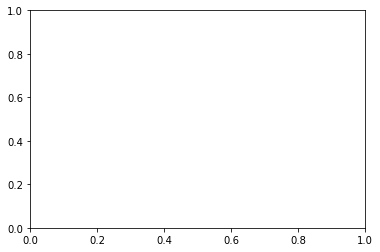

In [45]:
prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )

samplesk = []
n_samples = 10000
for kk in range(n_samples):
    samplesk.append(prior.sample())
    
print(prior)
plt.hist(samplesk)
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.title(f'{n_samples} samples drawn from Box Uniform prior\n low: 1.0000e-04; high: 0.0400')